In [1]:
import os.path
import time
import datetime as dt
import re
import csv
import statistics
import string
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

In [2]:
data_orig = pd.read_csv('dataset/amazon_reviews.txt', delimiter = "\t")
data = data_orig.copy()

In [3]:
data.head(1)

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."


In [4]:
data['labeled'] = ['Fake' if x =='__label1__' else 'Real' for x in data['LABEL']]

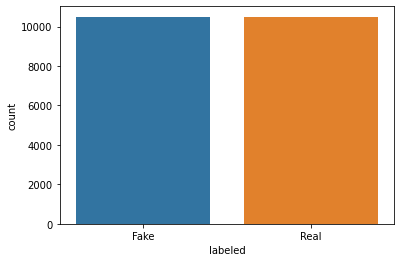

In [5]:
sns.countplot(data['labeled'])
plt.savefig('image/Data.png') 

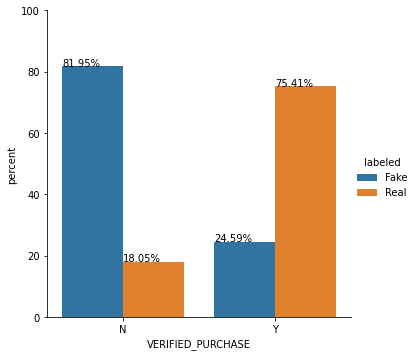

In [6]:
df= data
x,y = 'VERIFIED_PURCHASE', 'labeled'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
plt.savefig('image/Verified_purchase_percent.png') 

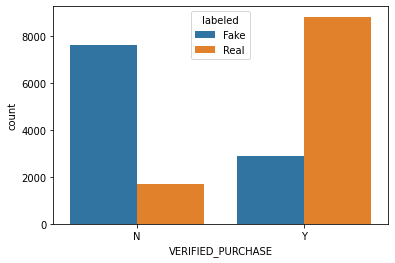

In [7]:
sns.countplot(x = 'VERIFIED_PURCHASE', hue='labeled', data=data)
plt.savefig('image/Verified_purchase.png') 

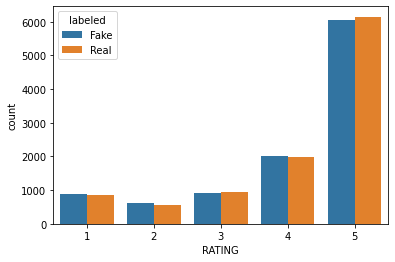

In [8]:
sns.countplot(x = 'RATING', hue='labeled', data=data)
plt.savefig('image/Rating_Labeled.png') 

In [9]:
negative_words= open("dataset/sentinent/negative-words.txt", "r")
positive_words= open("dataset/sentinent/positive-words.txt", "r")
negative_words_list = negative_words.read().splitlines() 
positive_words_list = positive_words.read().splitlines() 

In [10]:
data['REVIEW_TEXT'][:5]

0    When least you think so, this product will sav...
1    Lithium batteries are something new introduced...
2    I purchased this swing for my baby. She is 6 m...
3    I was looking for an inexpensive desk calcolat...
4    I only use it twice a week and the results are...
Name: REVIEW_TEXT, dtype: object

In [11]:
# Normalization
#     lower-case words
#     Change short term to long terms for verb.
#     remove punctuation
#         https://www.geeksforgeeks.org/python-remove-punctuation-from-string/
#     remove numbers

def normalization(word):
    word= word.lower()
    word = word.replace("'re",' are').replace("'m", ' am').replace("'s",' is').replace("n't",' not').replace("'ve",' have').replace("'d",' had').replace("'ll",' will')
    word = word.replace("'",' ')
    word = re.sub(r'http\S+', ' ', word)
    word = word.replace("<br", ' ')
    word  = re.sub(r'[^\w\s]', ' ', word)
    word  = re.sub(r'[0-9]+', ' ', word)
    return word

In [12]:
# Preprocess dataset 
#   Normalization
#   Removed Stop words 
def preprocess(data):
    result = []
    for line in data:
        word = normalization(line)
        word = word.lower().strip().split()
        stopwords = nltk.corpus.stopwords.words("english")
        word = [w for w in word if not w in stopwords]
        word = " ".join(word)
        result.append(word)
    return result

In [13]:
data['Processed_Review_title'] = preprocess(data['REVIEW_TITLE'])

In [14]:
data['title_length'] = data['Processed_Review_title'].apply(lambda x:len(str(x).split()))

<AxesSubplot:xlabel='title_length', ylabel='Count'>

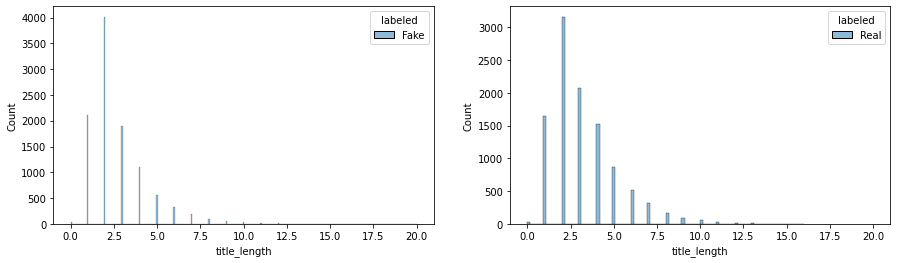

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,4))
sns.histplot(data[data['labeled']=='Fake'], x="title_length", hue="labeled",  ax=axes[0])

sns.histplot(data[data['labeled']== 'Real'], x="title_length", hue="labeled", ax=axes[1])

In [16]:
fake_data = data[data['labeled']=='Fake']
real_data = data[data['labeled']== 'Real']

In [17]:
# data.groupby(data['labeled']).RATING.value_counts()

In [18]:
print("Average Title Length of Fake Review: " +str(sum(fake_data['title_length'].values)/ len(fake_data['title_length'])))
print("Average Title Length of Real Review: " +str(sum(real_data['title_length'].values)/ len(real_data['title_length'])))    

Average Title Length of Fake Review: 2.7381904761904763
Average Title Length of Real Review: 3.1863809523809525


In [19]:
def p_n_count(df):
    ncount, pcount =0, 0
    for i in df.strip().split():
        if i in negative_words_list:
            ncount +=1
        if i in positive_words_list:
            pcount +=1
    return [ncount,pcount]

In [20]:
data['Processed_Review_text'] = preprocess(data['REVIEW_TEXT'])

In [21]:
data['review_content_length']= data['Processed_Review_text'].apply(lambda x:len(str(x).split()))

In [22]:
data.head(1)

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,labeled,Processed_Review_title,title_length,Processed_Review_text,review_content_length
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",Fake,useful,1,least think product save day keep around case ...,10


In [23]:
p_n_list =[]
for i in range(len(data['Processed_Review_text'])):
    p_n_list.append(p_n_count(data['Processed_Review_text'][i]))

In [24]:
score_list =[]
for i in range(len(data['Processed_Review_text'])):
    if sum(p_n_list[i]) == 0:
        score_list.append((p_n_list[i][1] - p_n_list[i][0]) / 1)
    else:
        score_list.append((p_n_list[i][1] - p_n_list[i][0]) / sum(p_n_list[i]))

In [25]:
data['polarity'] = score_list

In [26]:
def sentiment(data):
    sentiment_result =[]
    for i in range(len(data['polarity'])):
        if 0.25 <= data['polarity'][i]:
            sentiment_result.append('Positive')
        if -0.25 <=  data['polarity'][i] <0.25:
            sentiment_result.append('Neutral')
        if data['polarity'][i] <-0.25:
            sentiment_result.append('Negative')
    return sentiment_result 

In [27]:
data['sentiment'] = sentiment(data)

In [28]:
fake_data = data[data['labeled']=='Fake']
real_data = data[data['labeled']== 'Real']

In [29]:
fake_wordcloud = WordCloud(background_color='white', max_words=200,max_font_size=40, random_state=42)\
                    .generate(str(list(fake_data['Processed_Review_text'])))
real_wordcloud = WordCloud(background_color='white', max_words=200,max_font_size=40, random_state=42)\
                    .generate(str(list(real_data['Processed_Review_text'])))

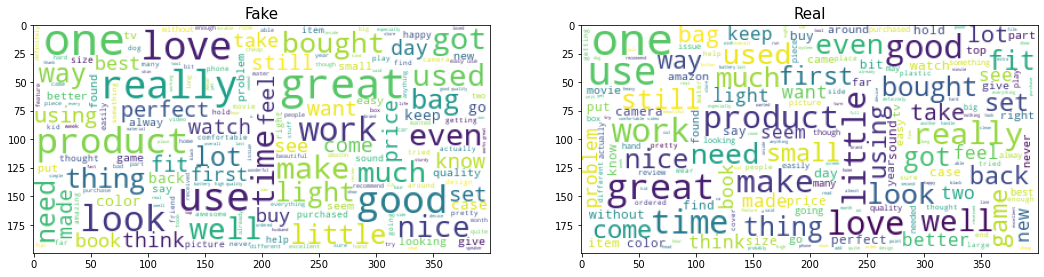

In [30]:
fig, axs = plt.subplots(1,2, figsize = (18,10))
fake_real_title_list =['Fake', 'Real']
fake_real_list =[fake_wordcloud,real_wordcloud]
m=0
for i in range(2):
    axs[i].set_title(fake_real_title_list[m], fontsize=15)
    axs[i].imshow(fake_real_list[m])
    m+=1
plt.savefig('image/Fake_Real_Wordcloud.png') 

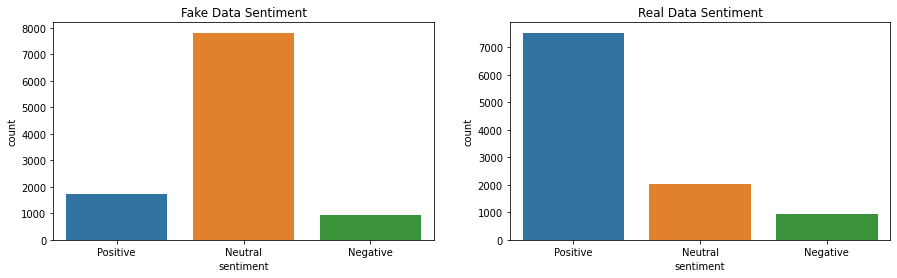

In [31]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,4))
sns.countplot(fake_data['sentiment'], ax=axes[0])
axes[0].set_title('Fake Data Sentiment')

sns.countplot(real_data['sentiment'], ax=axes[1])
axes[1].set_title('Real Data Sentiment')
plt.savefig('image/Fake_Real_Sentiment.png') 

<AxesSubplot:xlabel='review_content_length', ylabel='Count'>

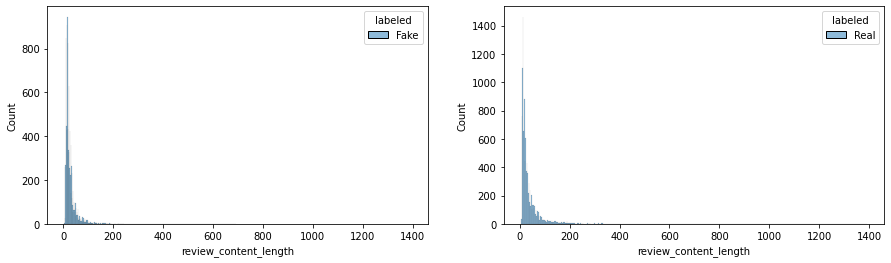

In [32]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,4))
sns.histplot(fake_data, x="review_content_length", hue="labeled",  ax=axes[0])

sns.histplot(real_data, x="review_content_length", hue="labeled", ax=axes[1])

In [33]:
print("Average Review Length of Fake Review: " +str(sum(fake_data['review_content_length'].values)/ len(fake_data['review_content_length'])))
print("Average Review Length of Real Review: " +str(sum(real_data['review_content_length'].values)/ len(real_data['review_content_length'])))    

Average Review Length of Fake Review: 28.53161904761905
Average Review Length of Real Review: 38.765904761904764


In [34]:
fake_positive = fake_data[fake_data['sentiment']=='Positive']['Processed_Review_text']
fake_neutral = fake_data[fake_data['sentiment']=='Neutral']['Processed_Review_text']
fake_negative = fake_data[fake_data['sentiment']=='Negative']['Processed_Review_text']

fake_p_wordcloud = WordCloud(background_color='white', max_words=200,max_font_size=40, random_state=42)\
                    .generate(str(list(fake_positive)))
fake_neu_wordcloud = WordCloud(background_color='white', max_words=200,max_font_size=40, random_state=42)\
                    .generate(str(list(fake_neutral)))
fake_n_wordcloud = WordCloud(background_color='white', max_words=200,max_font_size=40, random_state=42)\
                    .generate(str(list(fake_negative)))


real_positive = real_data[real_data['sentiment']=='Positive']['Processed_Review_text']
real_neutral = real_data[real_data['sentiment']=='Neutral']['Processed_Review_text']
real_negative = real_data[real_data['sentiment']=='Negative']['Processed_Review_text']

real_p_wordcloud = WordCloud(background_color='white', max_words=200,max_font_size=40, random_state=42)\
                    .generate(str(list(real_positive)))
real_neu_wordcloud = WordCloud(background_color='white', max_words=200,max_font_size=40, random_state=42)\
                    .generate(str(list(real_neutral)))
real_n_wordcloud = WordCloud(background_color='white', max_words=200,max_font_size=40, random_state=42)\
                    .generate(str(list(real_negative)))

In [35]:
wordcloud_title_list= ['Fake Positive', 'Real Positive','Fake Neutral','Real Neutral', 'Fake Negative', 'Real Negative']
wordcloud_list = [fake_p_wordcloud, real_p_wordcloud, fake_neu_wordcloud, real_neu_wordcloud, 
                  fake_n_wordcloud, real_n_wordcloud]                

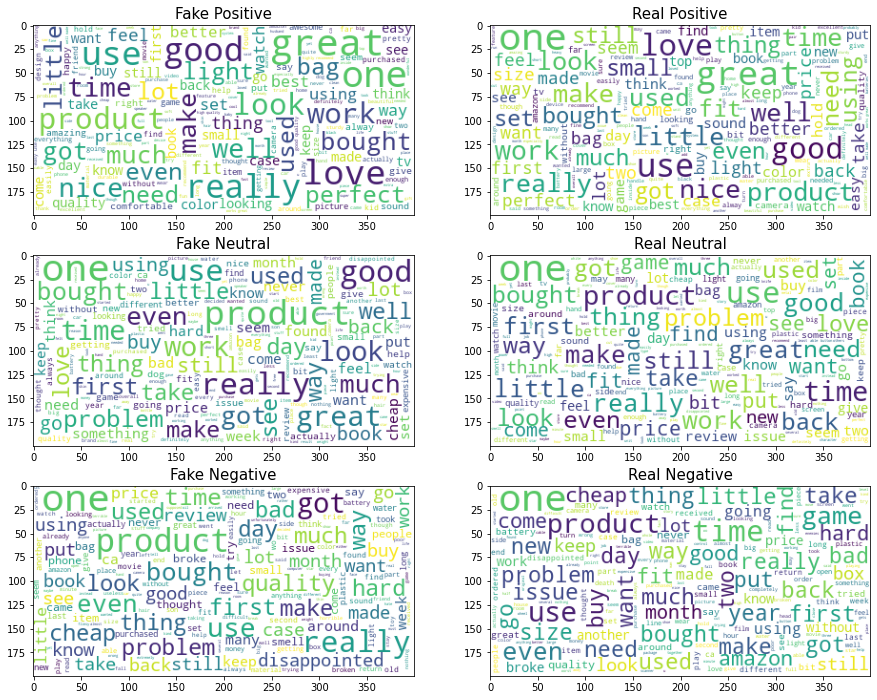

In [36]:
fig, axs = plt.subplots(3,2, figsize = (15,12))
m=0
for i in range(3):
    for j in range(2):
        axs[i,j].set_title(wordcloud_title_list[m], fontsize=15)
        axs[i,j].imshow(wordcloud_list[m])
        m+=1
plt.savefig('image/Fake_Real_Sentiment_WC.png') 

In [37]:
fake_dataset=str(list(fake_data['Processed_Review_text'])).lower().split()
real_dataset=str(list(real_data['Processed_Review_text'])).lower().split()

In [38]:
#fake_dataset
# real_dataset
unique_fake_list = list(set(fake_dataset) - set(real_dataset))
unique_real_list = list(set(real_dataset) - set(fake_dataset))

In [39]:
len(unique_fake_list), len(unique_real_list)

(8565, 16088)

In [40]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [41]:
union_fake_real = intersection(real_dataset, fake_dataset)

In [42]:
union_count = Counter(union_fake_real)
union_count_sort = sorted(union_count.items(), key=lambda x: x[1], reverse = True)

In [43]:
len(union_count)

15540

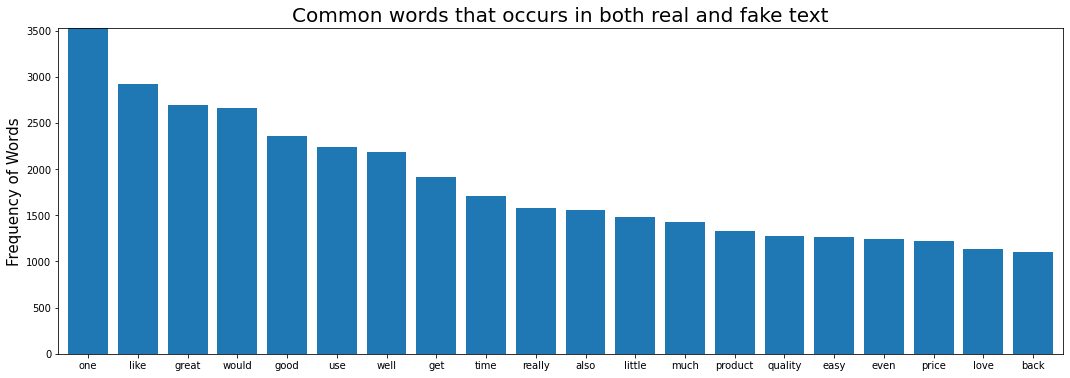

In [44]:
fig, ax1 = plt.subplots(figsize=(18, 6))
fake_x,fake_y = zip(*Counter(union_fake_real).most_common(20))
ax1.bar(fake_x,fake_y)
ax1.set_ylabel('Frequency of Words', fontsize=15)
ax1.margins(0.01,0)
plt.draw()
ax1.set_title('Common words that occurs in both real and fake text', fontsize=20)
plt.savefig('image/Common_both_real_fake.png') 

In [45]:
def remove(l1, l2):
    return [x for x in l1 if not any([x in l2])]

In [46]:
fake_unique = remove(fake_dataset, real_dataset)

In [47]:
real_unique = remove(real_dataset, fake_dataset)

In [48]:
print("Number of Unique Fake words: " +str(len(fake_unique)))
print("Number of Unique Real words: " +str(len(real_unique)))

Number of Unique Fake words: 11425
Number of Unique Real words: 25634


In [49]:
from collections import Counter

In [50]:
# fake_unique_count = Counter(fake_unique)
# real_unique_count = Counter(real_unique)

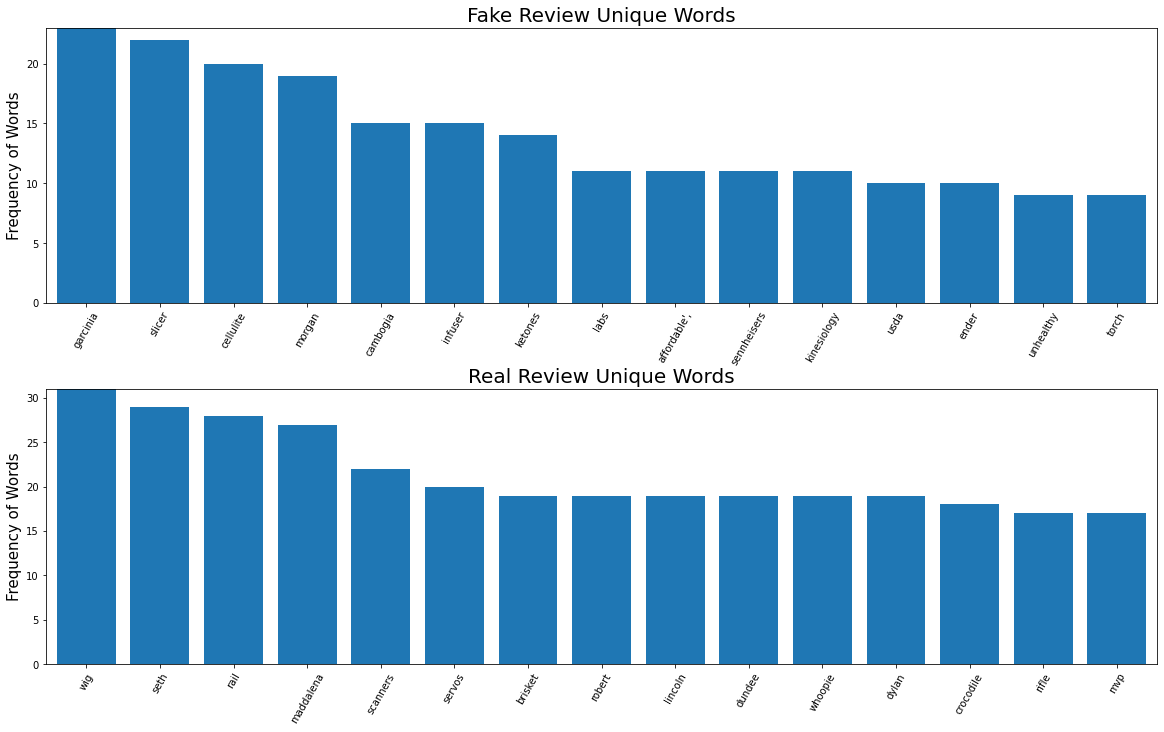

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
fake_x,fake_y = zip(*Counter(fake_unique).most_common(15))
real_x,real_y = zip(*Counter(real_unique).most_common(15))
ax1.bar(fake_x,fake_y)
ax1.set_ylabel('Frequency of Words', fontsize=15)
ax2.bar(real_x,real_y)
ax2.set_ylabel('Frequency of Words', fontsize=15)
ax1.margins(0.01,0)
plt.draw()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60);
ax1.set_title('Fake Review Unique Words', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60);
ax2.set_title('Real Review Unique Words', fontsize=20)
ax2.margins(0.01,0)
fig.tight_layout(pad=0.1)
plt.savefig('image/Unique_Fake_Real.png') 

In [52]:
data.head(1)

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,labeled,Processed_Review_title,title_length,Processed_Review_text,review_content_length,polarity,sentiment
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",Fake,useful,1,least think product save day keep around case ...,10,0.0,Neutral


In [53]:
data.groupby(['labeled','RATING','sentiment'])['review_content_length'].mean().unstack()

sentiment        Negative    Neutral   Positive
labeled RATING                                 
Fake    1       24.851190  37.882166  29.251046
        2       20.347619  29.720812  26.136364
        3       22.354331  25.611354  23.721053
        4       23.855932  27.782334  24.230179
        5       29.550000  36.022355  29.806044
Real    1       29.344118  45.783394  33.745020
        2       29.816000  50.737624  39.504202
        3       46.078125  50.007380  41.069982
        4       47.380952  63.213115  41.619972
        5       34.699571  49.288684  33.260491

In [54]:
data_new = data.copy()

In [55]:
data_new.head(1)

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,labeled,Processed_Review_title,title_length,Processed_Review_text,review_content_length,polarity,sentiment
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",Fake,useful,1,least think product save day keep around case ...,10,0.0,Neutral


In [57]:
data_new2 = data_new[['RATING', 'VERIFIED_PURCHASE', 'labeled', 'REVIEW_TEXT', 'Processed_Review_text', 'review_content_length','polarity', 'sentiment']]

In [58]:
data_new2.head(1)

,RATING,VERIFIED_PURCHASE,labeled,REVIEW_TEXT,Processed_Review_text,review_content_length,polarity,sentiment
0,4,N,Fake,"When least you think so, this product will sav...",least think product save day keep around case ...,10,0.0,Neutral


In [59]:
data_new2['VERIFIED_PURCHASE'] = [0 if x =='N' else 1 for x in data['VERIFIED_PURCHASE']]
data_new2['labeled'] = [0 if x =='Fake' else 1 for x in data['labeled']]

In [60]:
data_new2['sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [61]:
data_new2.head(1)

,RATING,VERIFIED_PURCHASE,labeled,REVIEW_TEXT,Processed_Review_text,review_content_length,polarity,sentiment
0,4,0,0,"When least you think so, this product will sav...",least think product save day keep around case ...,10,0.0,Neutral


In [62]:
from textblob import TextBlob

In [63]:
subjectivity_list=[]
for i in range(len(data_new2['Processed_Review_text'])):
    subjectivity_list.append(TextBlob(data_new2['Processed_Review_text'][i]).sentiment.subjectivity)

In [64]:
data_new2['subjectivity'] = subjectivity_list

In [65]:
data_new2.head(1)

,RATING,VERIFIED_PURCHASE,labeled,REVIEW_TEXT,Processed_Review_text,review_content_length,polarity,sentiment,subjectivity
0,4,0,0,"When least you think so, this product will sav...",least think product save day keep around case ...,10,0.0,Neutral,0.4


In [70]:
def getsubjective_Analysis(score):
    if score <= 0.5:
        return 'Objective'
    else:
        return 'Subjective'

In [71]:
data_new2['subjective_sentiment'] = data_new2['subjectivity'].apply(getsubjective_Analysis)

In [72]:
data_new2.head(1)

,RATING,VERIFIED_PURCHASE,labeled,REVIEW_TEXT,Processed_Review_text,review_content_length,polarity,sentiment,subjectivity,subjective_sentiment
0,4,0,0,"When least you think so, this product will sav...",least think product save day keep around case ...,10,0.0,Neutral,0.4,Objective


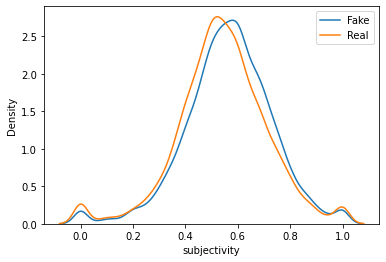

In [73]:
sns.distplot(data_new2[data_new2['labeled']==0]['subjectivity'], hist=False)
sns.distplot(data_new2[data_new2['labeled']==1]['subjectivity'], hist=False)
plt.legend(labels=['Fake', 'Real'])
plt.savefig('image/subjectivity_labeled.png') 

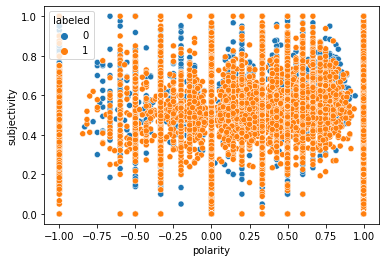

In [83]:
sns.scatterplot(data=data_new2, x="polarity", y="subjectivity", hue="labeled")
plt.savefig('image/polarity_subjectivity.png') 

In [75]:
data_new3 = data_new2.copy()

In [76]:
data_new3.head(1)

,RATING,VERIFIED_PURCHASE,labeled,REVIEW_TEXT,Processed_Review_text,review_content_length,polarity,sentiment,subjectivity,subjective_sentiment
0,4,0,0,"When least you think so, this product will sav...",least think product save day keep around case ...,10,0.0,Neutral,0.4,Objective


In [ ]:
aaaaaaaaa

In [77]:
from sklearn.utils import shuffle

In [78]:
data_new3  = shuffle(data_new3)
data_new3.reset_index(inplace=True, drop=True)

In [79]:
data.to_csv('dataset/processed_data.csv', sep='\t', encoding='utf-8')

In [80]:
data_new2.to_csv('dataset/processed_data2.csv', sep='\t', encoding='utf-8')

In [81]:
data_new3.to_csv('dataset/processed_data3_shuffled.csv', sep='\t', encoding='utf-8')